In [1]:
%config Completer.use_jedi = False

In [2]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
from JMetalPy_modified import *
import copy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK50_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/UK50_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

In [3]:
station_coordinates

,Unnamed: 0,City Name,lat,lng
0,0,Burgess_Hill,50.957537,-0.133285
1,1,South_Ockendon,51.509377,0.282794
2,2,Chorleywood,51.654176,-0.518356
3,3,Crowborough,51.059003,0.163586
4,4,Saint_Albans,51.749296,-0.342253
5,5,Strood,51.395857,0.495080
6,6,Radlett,51.683724,-0.318869
7,7,Tadley,51.341447,-1.144678
8,8,Slough,51.511101,-0.594068
9,9,Dartford,51.444306,0.218070


In [4]:
#save_here_data("../datasets/","UK50_2",distance_matrix_here,time_matrix_here)

In [5]:
from itertools import chain

def cheapest_insertion(nodes,start_positions,end_positions,distance_matrix,demands,maxLoad):
    
    def _get_total_path_capacity(path,customer_demands):
        return np.sum([customer_demands[p] for p in path])

    paths = [[x] for x in start_positions]
    visit_us = list(set(nodes)  - set(start_positions) - set(end_positions))
    while len(visit_us) > 0 :
        cheapest_insertion = (0,0)
        cheapest_cost = 10e10
        for node in visit_us:
            for path_index,path in enumerate(paths):
                cost = distance_matrix.iloc[path[-1]][node]
                if cost < cheapest_cost:
                    
                    if _get_total_path_capacity(path,demands) < maxLoad:
                        cheapest_insertion = (path_index,node)
                        cheapest_cost = cost
                        
        paths[cheapest_insertion[0]].append(cheapest_insertion[1])
        visit_us.remove(cheapest_insertion[1])
    
    temp_ends = copy.copy(end_positions)
    
    for ind,path in enumerate(paths):
        min_cost = 10e10
        min_end = 0
        for end in temp_ends:
            cost = distance_matrix.iloc[path[-1]][end]
            if cost < min_cost:
                min_end = end
                min_cost = cost
                
        path.append(min_end)
        temp_ends.remove(min_end)
            
    return {"paths":paths,"flattened":list(chain(*paths))}

In [6]:
def create_initial_solution(nodes,start_positions,end_positions,transit_cost_function,cost_function_parameter_dict:dict):
    result = []
    if(end_positions != None):
        pickup_points = list(set(set(nodes) - set(end_positions)) - set(start_positions))
    else:
        pickup_points = list(set(nodes) - set(start_positions))
    randVal = random.random()
    ends = copy.copy(end_positions)

    for start_pos in start_positions:
        result.append(start_pos)
        node_amount = int(len(pickup_points)/len(start_positions))
  
        closest_positions = sorted(pickup_points, key = lambda node: transit_cost_function(start_pos,node,**cost_function_parameter_dict))[:node_amount]

        for taken_position in closest_positions:
            pickup_points.remove(taken_position)
            result.append(taken_position)
        
        if len(ends) > 1:
            closest_end = sorted(ends, key = lambda node: transit_cost_function(result[-1],node,**cost_function_parameter_dict))[0]
        elif len(ends) == 1:
            closest_end = ends[0]
        
        result.append(closest_end)
        ends.remove(closest_end)
        
        
        
    for node in pickup_points:
        if node not in result:
            result.insert(1,node)

    return result

def shuffle_paths(variables,starts,ends):
    #random.seed(1)
    
    result = []
    start_indices = []
    end_indices = []
    for start,end in zip(starts,ends):
        end_indices.append(variables.index(end))
        start_indices.append(variables.index(start))
    end_indices.sort()
    start_indices.sort()
    
    for start, end in zip(start_indices,end_indices):
        result.append(variables[start])
        result.extend(random.sample(variables[start+1:end],k=len(variables[start+1:end])))
        result.append(variables[end])
        
    #random.seed()
    return result
            


In [7]:
# Tests of all different algorithms on different versions of UK-data
# Dynamic traffic scenarios for final report, compare if one does replan vs if one doesn't replan when e.g. a vehicle breaks down
# Compare with real data, how good is our method at estimating the fuel consumption vs the real data
# Produce a couple of scenarios to test on

In [8]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
import collections
from bisect import bisect_left


class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        fuel_eq_types = {0:'linear',1:'wong'}
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.time_matrix = problemData['time_matrix']
        self.demands = problemData['demands']
        self.max_no_of_vehicle = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MINIMIZE,self.MINIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.start_positions = problemData['start_points']
        self.end_positions = problemData['end_points']
        self.number_of_variables = problemData['number_of_cities']
        self.depot = 0
        self.cost_history = []
        self.fuel_eq_type = fuel_eq_types[problemData['fuelEq']]
        self.name = 'VRP'
        self.assignClosestEndPoint = False
        self.initial_solution = problemData['initial_solution']
        
        
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        
        def split_paths(values,starts):
            result = []
            for start_index,start in enumerate(starts):
                index = values.index(start)
                if start_index == len(starts)-1:
                    result.append(values[index:])
                else:
                    next_index = values.index(starts[start_index+1])
                    result.append(values[index:next_index])
            return result
        
        fitness = 0
        
        permutation = list(map(int, solution.variables))
        
        start_positions = self.start_positions
        paths = list([[x] for x in start_positions])
        vehicles = 1
        current_load = 0
        vehicle_index=0
        ends = []
        solution.constraints = [0 for x in range(len(solution.constraints))]
#         #======================Construct paths==========================#
        for node_index in permutation:
            
            if not node_index in start_positions:
                if vehicle_index == len(paths):
                    solution.constraints[4] -= ((len(permutation)-1)-node_index)*1000
                    paths[-1].append(node_index)#solution=self.create_solution()
                    #break
                
                elif node_index in self.end_positions:
                    if not self.assignClosestEndPoint:
                        paths[vehicle_index].append(node_index)
                    vehicle_index+=1
                    current_load = 0
                else:
                    paths[vehicle_index].append(node_index)
        
        if self.assignClosestEndPoint:
            minNodes = 1
        else:
            minNodes = 2   
        solution.path=list(filter(lambda path: len(path)> minNodes,paths))
        
        # put filter here removing paths only consisting of start & end nodes 
        
        #================================================================#
        if self.assignClosestEndPoint and (self.end_positions != None):
            for index,path in enumerate(solution.path):
                solution.path[index].append(int(self.distance_matrix.iloc[self.end_positions,path[-1],].sort_values().index[0]))
            
        
        #======================CALCULATE FITNESS=========================#
        vehicle_empty_weight = 3000
        solution.vehicle_loads = []
        solution.vehicle_fuel_consumptions = []
        solution.vehicle_route_distances = []
        solution.vehicle_route_times = []
        
        
        dist = 0
        for vehicle_route in solution.path:
            vehicle_load = 0
            vehicle_fuel_consumption = 0
            vehicle_route_distance = 0
            vehicle_route_time = 0
            total_vehicle_weight = vehicle_empty_weight
            
            for node_index in range(len(vehicle_route)-1):
                from_node = vehicle_route[node_index]
                to_node = vehicle_route[node_index + 1]
                
                if self.fuel_eq_type == 'linear':
                
                    vehicle_fuel_consumption += fuel_consumption_linear(from_node=from_node,to_node=to_node,
                                                                        distance_matrix=self.distance_matrix,demands=self.demands,
                                                                        cumulative_route_load=vehicle_load,meta_data=meta_data)
                
                elif self.fuel_eq_type == 'wong':
                    
#                     vehicle_fuel_consumption += fuel_consumption_wong(from_node=from_node,to_node=to_node,
#                                                                      distance_matrix=self.distance_matrix,time_matrix= self.time_matrix,
#                                                                      demands=self.demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
#                                                                      start_positions=self.start_positions,meta_data=meta_data)
                                                
                        
                        
                    vehicle_fuel_consumption += fuel_consumption_rauniyar(from_node=from_node,to_node=to_node,
                                                                 distance_matrix=self.distance_matrix,time_matrix=self.time_matrix,
                                                                 demands=self.demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
                                                                 start_positions=self.start_positions)
                        
                vehicle_load += demand_callback(from_node,self.demands,self.start_positions)
                vehicle_route_distance += self.distance_matrix.iloc[from_node][to_node]
                vehicle_route_time += self.time_matrix.iloc[from_node][to_node]
                

            #Increment fitness value
            fitness += vehicle_fuel_consumption
            dist += vehicle_route_distance
            solution.totalFuelConsumption = fitness
            solution.vehicle_route_distances.append(round(vehicle_route_distance,2))
            solution.vehicle_fuel_consumptions.append(vehicle_fuel_consumption)
            solution.vehicle_route_times.append(vehicle_route_time)
            solution.vehicle_loads.append(vehicle_load)
        #=================================================================#
        
        solution.total_DriveTime = sum(solution.vehicle_route_times)/(60)
        solution.longest_DriveTime = max(solution.vehicle_route_times)/60
        solution.shortest_DriveTime = min(solution.vehicle_route_times)/60
        
        #fitness += max(solution.vehicle_fuel_consumptions)*2 #+ max(solution.vehicle_route_times)
        
        solution.flag = []
        #============CHECK CONSTRAINTS==============
        #All nodes must be visited
        if self.assignClosestEndPoint:
            allNodes = list(set(copy.copy(permutation))-set(self.end_positions))
        else:
            allNodes = copy.copy(permutation)
            
        if not self.__allVisited(allNodes,solution.path,ends):
            solution.constraints[0] = -100
            solution.flag.append("visited")
        
        if self.__overLoaded(solution.path):
            solution.constraints[1] = 3650 - max(solution.vehicle_loads)
            solution.flag.append("overload")
        
        if not self.__correctStart(solution.path):
            solution.constraints[2] = -100
            solution.flag.append("start")
        
        if max(solution.vehicle_route_times) > (7*60*60):
            solution.constraints[3] = (7*60*60) - max(solution.vehicle_route_times)
            solution.flag.append("time")

        # If end nodes are set, all paths must end at the one of the end nodes
        if self.end_positions != None:
            final_path_positions = [path[-1]  for path in solution.path]
            faultyEndpoints = self.__checkEndPoints(final_path_positions)
            if  faultyEndpoints > 0:
                solution.constraints[4] = -faultyEndpoints*1000 
                #solutions.constraints += len(np.hstack(solution.path).tolist()) - 
                solution.flag.append("end")
                
        if self.name in ["SA","GA","IBEA"]:
            for constraint_val in solution.constraints:
                fitness += abs(constraint_val)
        
        # If cumulative drive time > 8 hours, add 10e10 to fitness
        #===========================================
        
        
        if len(solution.objectives)==2:
            solution.objectives[0] = fitness
            # Change to longest individual drivetime
            solution.objectives[1] = solution.total_DriveTime# solution.longest_DriveTime#
            
        if len(solution.objectives) == 1:
            solution.objectives[0] = fitness +  solution.total_DriveTime #
        
        # Update objective fitness
        if fitness < 10e10:
            self.cost_history.append(fitness)
            
            
        #print(len(solution.variables))
        return solution
    
    def __correctStart(self,paths):
        firstcheck = paths[0][0] in self.start_positions 
        
        secondcheck = True
        for path in paths:
            if len(set(path).intersection(set(self.start_positions))) > 1:
                secondcheck = False
        return firstcheck * secondcheck
        
        
        
    def __overLoaded(self,paths):
        for path, capacity in zip(paths,self.vehicle_capacities):
            load = 0
            for i in range(len(path)):
                load += demand_callback(from_node=path[i],demands=self.demands,start_nodes=self.start_positions)
            if load > capacity:
                return True
        
            
            
    def __checkEndPoints(self,ends):
        errorCount = 0 
        for end in ends:
            if end not in self.end_positions:
                errorCount +=1
        return errorCount
        #return set(ends).issubset(set(self.end_positions))
    
    def __containsNoEndPoints(self,paths):
        return set(self.end_positions).isdisjoint(set(chain.from_iterable(paths)))
    
    def __allVisited(self,variables,paths,ends):
        points = list(set(variables) - set(ends))
        return set(points).issubset(set(chain.from_iterable(paths)))
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        routes = []
        for index in range(len(solution.path) - 1):
            if solution.path[index] == 0 :
                routes.append([0])
            else:
                routes[-1].append(solution.path[index])
                

        return routes
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives,number_of_constraints=self.number_of_constraints)
    
        
        self.start_positions = random.sample(self.start_positions,k=len(self.start_positions))

        cost_function_dict = {"distance_matrix":self.distance_matrix,"time_matrix":self.time_matrix,
                              "demands":self.demands,"vehicle_weight":3000,"start_positions":self.start_positions,"meta_data":meta_data}

        nodes = {}
        if self.end_positions != None:
            node_amount = list(range(self.number_of_variables))


        new_solution.variables = self.initial_solution
        #new_solution.variables = shuffle_paths(new_solution.variables,self.start_positions,self.end_positions)
# #create_initial_solution(node_amount,self.start_positions,self.end_positions, fuel_consumption_wong,cost_function_dict)

        if not self.name in ["SA","LS"]:
            if random.random() < 0.8:
                new_solution.variables = random.sample(self.initial_solution,k=len(self.initial_solution))#shuffle_paths(new_solution.variables,self.start_positions,self.end_positions)
#             else:
#                 new_solution.variables = random.sample(list(range(self.number_of_variables)),k=self.number_of_variables)
        
        return new_solution
        
    def get_name(self):
        return self.name

In [9]:
def saveParameterData(path,name,data):
    DF = pd.DataFrame(data)
    DF.to_csv("{}{}.csv".format(path,name),index=False)

In [10]:
starts =[0,6,10,15,21,35,40]
vehicle_amount = len(starts)
ends = [4,20,2,5,32,45,1]
customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
customer_demands[ends] = 0

station_data["Demand(kg)"][starts] = 0
station_data["Demand(kg)"][ends]= 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = distance_matrix_here
nodes = list(range(len(customer_demands)))

cost_function_dict = {"distance_matrix":distance_matrix,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":starts,"meta_data":meta_data}


initial_solution = cheapest_insertion(nodes,starts,ends,distance_matrix,customer_demands,3650)

data_model_input_single_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':1,'objective_labels':['Total Fuel'],'constraint_amount':5,
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1,'initial_solution':initial_solution["flattened"]}



data_model_input_multi_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],'constraint_amount':5,
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1,'initial_solution':initial_solution["flattened"]}

amount_of_runs = 30
amount_of_evaluations = 2000

mutation_arange = np.arange(0.1,1,0.1)
crossover_arange = np.arange(0.2,0.9,0.15)



#logPath = "../logs/UK50_1_Logs_2/"#"../logs/{}-{}-{}-{}-{}/".format(datetime.today().year,datetime.today().month,datetime.today().day,datetime.today().hour,datetime.today().minute)
# if not os.path.exists(logPath):
#     try:
#         os.mkdir(logPath)
#     except OSError:
#         print ("Creation of the directory %s failed" % logPath)
#     else:
#         print ("Successfully created the directory %s " % logPath)

In [11]:
from jmetal.core.observer import Observer
from IPython.display import clear_output
from jmetal.core.quality_indicator import InvertedGenerationalDistance,HyperVolume
import logging
LOGGER = logging.getLogger('jmetal')
# UPDATE OBSERVER TO GET BEST FUEL CONSUMPTION FROM THE SOLUTION IN THE CURRENT PARETO FRONT WITH THE BEST CONSUMPTION
class PerformanceObserver(Observer):
    def __init__(self, max_iter:int,frequency: float = 1.0,params = []) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.performances = []
        self.max_iter = max_iter
        self.currentBestFitness = [10e10]
        self.currentBestDriveTime = [10e10]
        self.currentBestFuelConsumption =[10e10]
        self.total_consumptions = []
        self.currentEpoch = 0
        self.maxEpochs = 0
        self.params= params
        self.current_params = ""
        self.maxDriveTimes = []
        self.bestFitnessTime=0
        self.violations = []
        self.IGD = InvertedGenerationalDistance([[0,0]])
        self.currentBestIGD = 0
        self.IGD_values = []
        self.fronts = []
        self.front_history = []
        
        
    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']
        allSolutions = kwargs['SOLUTIONS']
        if type(solutions) == list:
            self.fronts.append(get_non_dominated_solutions(solutions))
            solution = get_non_dominated_solutions(solutions)[0]#solutions[0]
        else:
            solution = solutions
        runAmount = self.maxEpochs/len(self.params)
        self.current_params = str(self.params[int(self.currentEpoch/runAmount)])
        
        if hasattr(solution, 'vehicle_fuel_consumptions'):    
            
            if (evaluations % self.display_frequency) == 0 and solution:
                fitness = solution.objectives
                consumption = sum(solution.vehicle_fuel_consumptions)
                flags=solution.flag
                if len(fitness) == 1:
                    self.performances.append(fitness[0])
                else:
                    self.performances.append(fitness)
                    
                self.maxDriveTimes.append(max(solution.vehicle_route_times))
                self.total_consumptions.append(consumption)
                self.computing_time = computing_time
                current_route = solution.path
                #if fitness[0] < self.currentBestFitness[0]:
                self.currentBestFitness = fitness#[0]
                self.bestFitnessTime = computing_time
                self.currentBestDriveTime = solution.total_DriveTime
                self.currentBestFuelConsumption = solution.totalFuelConsumption
                self.front_history.append([self.currentBestFuelConsumption,self.currentBestDriveTime])    
                self.violations.append(overall_constraint_violation_degree(solution))
                clear_output(wait=True)
                if len(fitness) == 1:
                    self.currentIGD = self.IGD.compute([[self.currentBestFuelConsumption,self.currentBestDriveTime]])
                    
                    
                    print("Epoch:{} of {}\nEvaluations: {}/{}\nParams: {}\nIGD:{}\nBest fitness: {}\
                          \nBest total fuel consumption:{} \nBest total drive time:{}\
                          \nComputing time: {}s\nAverage computing speed: {}it/s\
                          \nCurrent Route:{}\nFlags: {}\nViolation:{}\nVehicle Amount:{}".format(
                            self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter,self.current_params,self.currentIGD, 
                            round(self.currentBestFitness[0],4),round(consumption,2),round(self.currentBestDriveTime,2), 
                            round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                        ,overall_constraint_violation_degree(solution),len(current_route)),flush=True)
                    
                elif len(fitness)== 2:
                    if type(allSolutions) == list:
                        objec = [x.objectives for x in get_non_dominated_solutions(allSolutions)]
                        self.currentIGD = self.IGD.compute(objec)
                    else:
                        self.currentIGD = self.IGD.compute([[self.currentBestFuelConsumption,self.currentBestDriveTime]])
                    
                    print("Epoch:{} of {}\nEvaluations: {}/{}\nParams: {} \nIGD:{}\nBest fitness: {} --- {}\
                        \nBest total fuel consumption:{} \nComputing time: {}s\
                        \nAverage computing speed: {}it/s\nCurrent Route:{}\nFlags: {}\
                        \nViolation:{}\nVehicle amount:{}".format(
                        
                        self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter,self.current_params,self.currentIGD,
                        round(self.currentBestFitness[0],4),round(self.currentBestFitness[1],4),round(self.currentBestFitness[0],2), 
                        round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                        ,overall_constraint_violation_degree(solution),len(current_route)),
                          flush=True)
                
                self.IGD_values.append(self.currentIGD)
                
                

In [29]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_SA = [{"mutation":0.9}]#,{"mutation":0.5}]
# for x in mutation_arange:
#     parameter_list_SA.append({"mutation":np.round(x,2)})
parameter_data_SA = []
computation_times_SA = []
results_SA = []

for index,param in enumerate(parameter_list_SA):
    plot_data_SA = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
    for x in range(1):
        problem_SA = VRP(data_model_input_single_objective)
        problem_SA.name = "SA"
        problem_SA.assignClosestEndPoint = True
        max_evaluations = 5000

        algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                       mutation=PermutationSwapMutation(param["mutation"]),
                                       termination_criterion=StoppingByEvaluations(max_evaluations))
      
        performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_SA)
        performance_observer_SA.maxEpochs= len(parameter_list_SA) * amount_of_runs
        performance_observer_SA.currentEpoch = (index*amount_of_runs) + x

        algorithm_SA.observable.register(observer=performance_observer_SA)
        algorithm_SA.run() 
        
        solutions_SA = algorithm_SA.get_result()
        
        
        plot_data_SA['fitness'].append(performance_observer_SA.performances)
        plot_data_SA['fuel_consumption'].append(performance_observer_SA.total_consumptions)
        plot_data_SA['optimal_time'].append(performance_observer_SA.bestFitnessTime)
        plot_data_SA['maxDriveTimes'].append(performance_observer_SA.maxDriveTimes)
        plot_data_SA['violation'].append(performance_observer_SA.violations)
        plot_data_SA['paths'].append(solutions_SA.path)
        plot_data_SA['IGD'].append(performance_observer_SA.IGD_values)
        sa_fronts = performance_observer_SA.front_history
        
    param["paramGroup"] = index
    param["algorithm"] = problem_SA.name

    parameter_data_SA.append({"parameters":param,"results":plot_data_SA})
    
    solutions_SA = algorithm_SA.get_result()
    print("Feasible solution found: {}".format(is_feasible(solutions_SA)))
    results_SA.append(get_results(solutions_SA.path,problem_SA.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_SA.append(performance_observer_SA.computing_time)
final_results_SA = generate_final_results(results_SA, computation_times_SA)
final_results_SA

#saveParameterData(logPath,"SA_data",parameter_data_SA)

Epoch:1 of 30
Evaluations: 5000/5000
Params: {'mutation': 0.9}
IGD:1641.7307117001312
Best fitness: 1836.1181                          
Best total fuel consumption:200.7 
Best total drive time:1629.42                          
Computing time: 59.19s
Average computing speed: 84.48it/s                          
Current Route:[[21, 43, 22, 42, 34, 19, 28, 23, 9, 1], [15, 31, 46, 8, 37, 44, 7, 48, 2], [40, 11, 18, 39, 20], [6, 47, 29, 16, 38, 24, 27, 2], [35, 36, 17, 25, 13, 14, 50, 26, 41, 45], [0, 30, 33, 49, 3, 12, 20]]
Flags: ['overload']
Violation:-6
Vehicle Amount:6
Feasible solution found: False


,Max,Min,Mean,Std
Total distance (km),1291.794000,1291.794000,1291.794000,NaN
Total load (kg),17285,17285,17285.000000,NaN
Total Estimated Fuel Consumption (L) (Hao et al.),175.926959,175.926959,175.926959,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.498387,13.498387,13.498387,NaN
Total Estimated Fuel Consumption (L) (Wong et al.),140.000242,140.000242,140.000242,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),10.734737,10.734737,10.734737,NaN
Avg Speed (km/h),45.881408,45.881408,45.881408,NaN
Computaion Time,59.186872,59.186872,59.186872,NaN


In [71]:
from jmetal.algorithm.singleobjective import LocalSearch
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_LS =[{"mutation":0.9}]
# for x in mutation_arange:
#     parameter_list_LS.append({"mutation":np.round(x,2)})
parameter_data_LS = []
computation_times_LS = []
results_LS = []

for index,param in enumerate(parameter_list_LS):
        plot_data_LS = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
        for x in range(20):
            problem_LS = VRP(data_model_input_single_objective)
            problem_LS.name = "LS"
            problem_LS.assignClosestEndPoint = True
            max_evaluations = amount_of_evaluations

            algorithm_LS = LocalSearch(problem=problem_LS,
                                           mutation=PermutationSwapMutation(param["mutation"]),
                                           termination_criterion=StoppingByEvaluations(max_evaluations),
                                          comparator=DominanceComparator())

            performance_observer_LS = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_LS)
            performance_observer_LS.maxEpochs= len(parameter_list_LS) * amount_of_runs
            performance_observer_LS.currentEpoch = (index*amount_of_runs) + x

            algorithm_LS.observable.register(observer=performance_observer_LS)
            algorithm_LS.run()
            
            
            solutions_LS = algorithm_LS.get_result()
            
            plot_data_LS['fitness'].append(performance_observer_LS.performances)
            plot_data_LS['fuel_consumption'].append(performance_observer_LS.total_consumptions)
            plot_data_LS['optimal_time'].append(performance_observer_LS.bestFitnessTime)
            plot_data_LS['maxDriveTimes'].append(performance_observer_LS.maxDriveTimes)
            plot_data_LS['violation'].append(performance_observer_LS.violations)
            plot_data_LS['IGD'].append(performance_observer_LS.IGD_values)
            plot_data_LS['paths'].append(solutions_LS.path)
            
        param["paramGroup"] = index
        param["algorithm"] = problem_LS.name
            
    
        parameter_data_LS.append({"parameters":param,"results":plot_data_LS})
        
        solutions_LS = algorithm_LS.get_result()
        print("Feasible solution found: {}".format(is_feasible(solutions_LS)))
        results_LS.append(get_results(solutions_LS.path,problem_LS.distance_matrix,station_data,meta_data,time_matrix_here))
        computation_times_LS.append(performance_observer_LS.computing_time)
final_results_LS = generate_final_results(results_LS, computation_times_LS)
final_results_LS

#saveParameterData(logPath,"LS_data",parameter_data_LS)

Epoch:20 of 30
Evaluations: 2000/2000
Params: {'mutation': 0.9}
IGD:1787.641284640715
Best fitness: 2007.852                          
Best total fuel consumption:235.84 
Best total drive time:1772.02                          
Computing time: 24.0s
Average computing speed: 83.32it/s                          
Current Route:[[35, 36, 43, 22, 33, 30, 28, 3, 20], [21, 14, 27, 24, 8, 7, 44, 41, 45], [10, 18, 39, 11, 49, 34, 19, 12, 20], [40, 42, 29, 16, 38, 31, 2], [0, 17, 25, 13, 50, 37, 26, 48, 2], [15, 9, 23, 47, 46, 2]]
Flags: []
Violation:0
Vehicle Amount:6
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),1514.218000,1514.218000,1514.218000,NaN
Total load (kg),17285,17285,17285.000000,NaN
Total Estimated Fuel Consumption (L) (Hao et al.),205.765117,205.765117,205.765117,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.504825,13.504825,13.504825,NaN
Total Estimated Fuel Consumption (L) (Wong et al.),165.844174,165.844174,165.844174,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),10.917724,10.917724,10.917724,NaN
Avg Speed (km/h),51.074079,51.074079,51.074079,NaN
Computaion Time,24.002490,24.002490,24.002490,NaN


In [17]:
saveParameterData(logPath,"LS_data_20_1_params",parameter_data_LS)

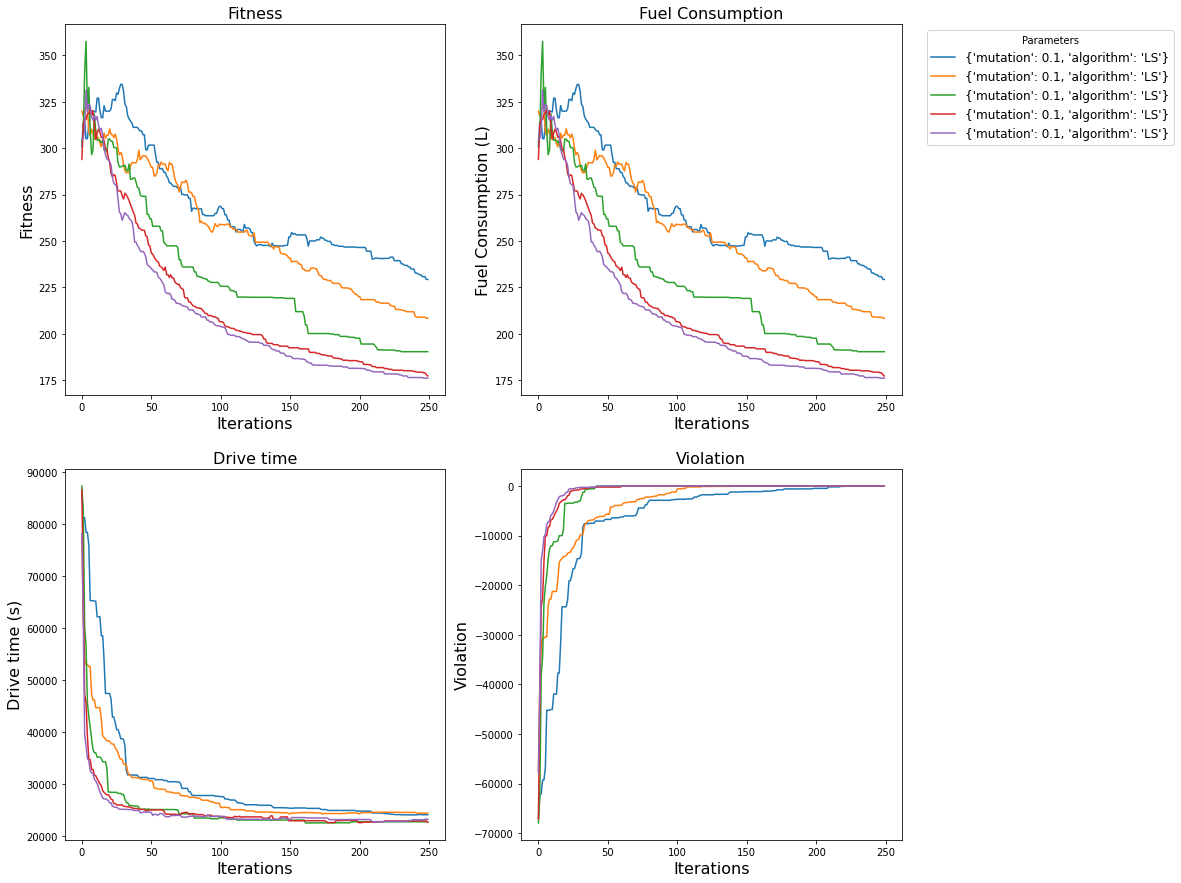

In [12]:
plotModelParameterComparison(parameter_data_LS,
                             ["fitness","fuel_consumption","maxDriveTimes","violation"],
                             ["Fitness","Fuel Consumption","Drive time","Violation"],
                             ["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"],5)

In [235]:
get_results(solutions_LS.path,problem_LS.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,422.304,1498,54.513586,12.908612,38.403841,9.093885,60.916552,24957,06:55:57.00
1,248.410,2535,34.086671,13.721940,23.191149,9.335836,56.596165,15801,04:23:21.00


In [12]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,BinaryTournament2Selection
from datetime import datetime
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = [{"mutation":0.8,"crossover":0.2}]
# for x in mutation_arange:
#     for y in crossover_arange:
#         parameter_list_NSGAIII.append({"mutation":round(x,2),"crossover":round(y,2)})
parameter_data_NSGAIII = []
computation_times_NSGAIII = []
results_NSGAIII = []
for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
    for x in range(1):
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = 5000
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=10,
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator()
                                   )

        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)

        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x
        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()

        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        plot_data_NSGAIII['fitness'].append(performance_observer_NSGAIII.performances)
        plot_data_NSGAIII['fuel_consumption'].append(performance_observer_NSGAIII.total_consumptions)
        plot_data_NSGAIII['optimal_time'].append(performance_observer_NSGAIII.bestFitnessTime)
        plot_data_NSGAIII['maxDriveTimes'].append(performance_observer_NSGAIII.maxDriveTimes)
        plot_data_NSGAIII['violation'].append(performance_observer_NSGAIII.violations)
        plot_data_NSGAIII['IGD'].append(performance_observer_NSGAIII.IGD_values)
        plot_data_NSGAIII['paths'].append(front_NSGAIII[0].path)
       
    
    param["paramGroup"] = index
    param["algorithm"] = problem_NSGAIII.name
    
    parameter_data_NSGAIII.append({"parameters":param,"results":plot_data_NSGAIII})
    
    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
    print("Feasible solution found: {}".format(is_feasible(front_NSGAIII[0])))
    results_NSGAIII.append(get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_NSGAIII.append(performance_observer_NSGAIII.computing_time)
final_results_NSGAIII = generate_final_results(results_NSGAIII,computation_times_NSGAIII)    
final_results_NSGAIII

#saveParameterData(logPath,"NSGA3_data",parameter_data_NSGAIII)

Epoch:1 of 30
Evaluations: 5000/5000
Params: {'mutation': 0.8, 'crossover': 0.2} 
IGD:1706.6703932815476
Best fitness: 205.4043 --- 1701.5                        
Best total fuel consumption:205.4 
Computing time: 15.58s                        
Average computing speed: 320.83it/s
Current Route:[[10, 22, 43, 42, 33, 28, 23, 9, 1], [15, 48, 31, 8, 37, 2], [0, 30, 19, 38, 2], [40, 11, 18, 39, 20], [6, 47, 34, 29, 16, 27, 24, 46, 2], [35, 17, 25, 13, 14, 50, 26, 2], [21, 36, 41, 44, 7, 49, 3, 12, 20]]
Flags: []                        
Violation:0
Vehicle amount:7
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),1347.854000,1347.854000,1347.854000,NaN
Total load (kg),17285,17285,17285.000000,NaN
Total Estimated Fuel Consumption (L) (Hao et al.),178.780149,178.780149,178.780149,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.258594,13.258594,13.258594,NaN
Total Estimated Fuel Consumption (L) (Wong et al.),145.234809,145.234809,145.234809,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),10.703868,10.703868,10.703868,NaN
Avg Speed (km/h),47.387959,47.387959,47.387959,NaN
Computaion Time,15.584552,15.584552,15.584552,NaN


Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

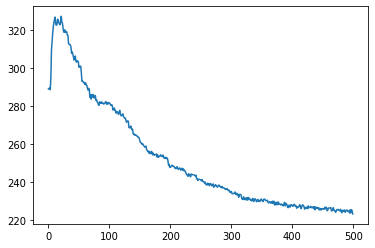

In [37]:
plt.plot(np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0))

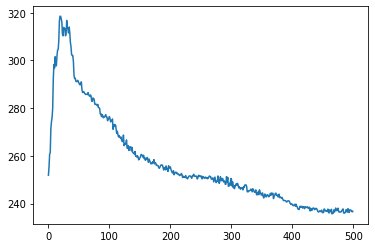

In [20]:
plt.plot(np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0))

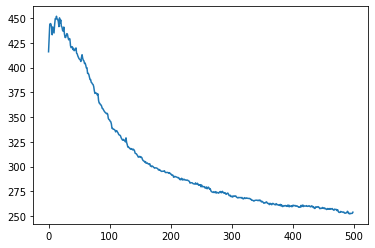

In [13]:
plt.plot(np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0))

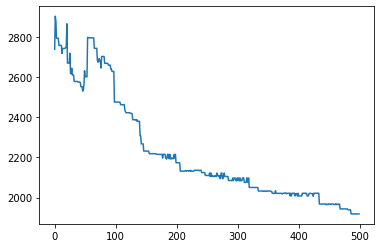

In [14]:
plt.plot(np.array(performance_observer_NSGAIII.front_history)[:,1])
plt.show()

In [47]:
saveParameterData(logPath,"NSGA3_data_10_pop_8_ref",parameter_data_NSGAIII)

In [13]:
get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,279.020,3406,37.651923,13.494346,30.359578,10.880789,50.251238,19989,05:33:09.00
1,246.430,2789,32.880499,13.342734,26.783172,10.868471,49.097792,18069,05:01:09.00
2,337.302,3019,44.708071,13.254612,36.837258,10.921150,53.511687,22692,06:18:12.00
3,173.471,1262,22.819158,13.154451,19.129519,11.027503,59.720340,10457,02:54:17.00
4,181.904,3260,24.201342,13.304458,19.609294,10.780023,51.036895,12831,03:33:51.00
5,179.183,2758,24.042168,13.417661,19.234259,10.734422,46.420466,13896,03:51:36.00
6,158.856,791,20.107667,12.657795,16.873871,10.622118,50.969840,11220,03:07:00.00


In [25]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_NSGAII = [{"mutation":0.8,"crossover":0.5}]#,{"mutation":0.8,"crossover":0.5}]
# for x in mutation_arange:
#     for y in crossover_arange:
#         parameter_list_NSGAII.append({"mutation":round(x,2),"crossover":round(y,2)})
parameter_data_NSGAII = []
computation_times_NSGAII = []
results_NSGAII = []
fronts2=[]
for index,param in enumerate(parameter_list_NSGAII):
    plot_data_NSGAII = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
    for x in range(1):
        problem_NSGAII = VRP(data_model_input_multi_objective)
        problem_NSGAII.name = "NSGA-II"
        problem_NSGAII.assignClosestEndPoint = True
        max_evaluations = 5000

        algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                                population_size=10,
                                offspring_population_size=10,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),

                                   )

        performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAII)
        performance_observer_NSGAII.maxEpochs= len(parameter_list_NSGAII) * amount_of_runs
        performance_observer_NSGAII.currentEpoch = (index*amount_of_runs) + x
        algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
        algorithm_NSGAII.run()
        
        solutions_NSGAII = algorithm_NSGAII.get_result()
        front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
        
        plot_data_NSGAII['fitness'].append(performance_observer_NSGAII.performances)
        plot_data_NSGAII['fuel_consumption'].append(performance_observer_NSGAII.total_consumptions)
        plot_data_NSGAII['optimal_time'].append(performance_observer_NSGAII.bestFitnessTime)
        plot_data_NSGAII['maxDriveTimes'].append(performance_observer_NSGAII.maxDriveTimes)
        plot_data_NSGAII['violation'].append(performance_observer_NSGAII.violations)
        plot_data_NSGAII['IGD'].append(performance_observer_NSGAII.IGD_values)
        plot_data_NSGAII['paths'].append(front_NSGAII[0].path)
        fronts2 = performance_observer_NSGAII.fronts
    param["paramGroup"] = index
    param["algorithm"] = problem_NSGAII.name
        
    parameter_data_NSGAII.append({"parameters":param,"results":plot_data_NSGAII})
    
    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    results_NSGAII.append(get_results(front_NSGAII[0].path,problem_NSGAII.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_NSGAII.append(performance_observer_NSGAII.computing_time)
final_results_NSGAII = generate_final_results(results_NSGAII,computation_times_NSGAII)    
final_results_NSGAII

#saveParameterData(logPath,"NSGA2_data",parameter_data_NSGAII)

Epoch:1 of 30
Evaluations: 5000/5000
Params: {'mutation': 0.8, 'crossover': 0.5} 
IGD:1839.0924128385843
Best fitness: 252.4495 --- 1821.6833                        
Best total fuel consumption:252.45 
Computing time: 14.24s                        
Average computing speed: 351.06it/s
Current Route:[[0, 43, 22, 42, 30, 33, 23, 9, 1], [10, 28, 27, 26, 37, 8, 24, 31, 2], [15, 38, 11, 18, 39, 12, 20], [35, 36, 16, 19, 34, 29, 47, 46, 2], [40, 17, 25, 13, 14, 50, 41, 45], [6, 48, 7, 44, 3, 49, 20]]
Flags: []                        
Violation:0
Vehicle amount:6


,Max,Min,Mean,Std
Total distance (km),1599.634000,1599.634000,1599.634000,NaN
Total load (kg),17285,17285,17285.000000,NaN
Total Estimated Fuel Consumption (L) (Hao et al.),213.489663,213.489663,213.489663,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.369318,13.369318,13.369318,NaN
Total Estimated Fuel Consumption (L) (Wong et al.),176.540054,176.540054,176.540054,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),10.990997,10.990997,10.990997,NaN
Avg Speed (km/h),51.971566,51.971566,51.971566,NaN
Computaion Time,14.242771,14.242771,14.242771,NaN


NameError: name 'vehicle_driveTimes_sa' is not defined

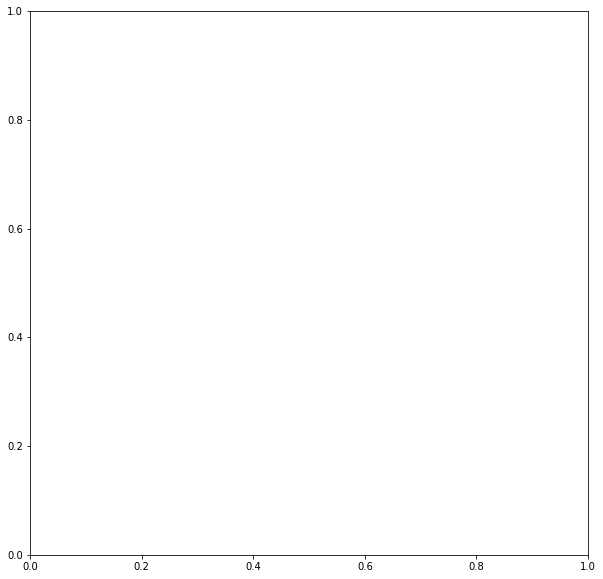

In [69]:
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.bar(np.array(range(0,len(vehicle_driveTimes_sa[0].keys())))-0.1,np.mean(driveTimes_list_ibea,axis=0),width=0.2,alpha=0.8,label=r"$\bf{SA}$",align="center")
#plt.bar(np.array(range(0,len(vehicle_driveTimes_ibea[0].keys())))+0.1,np.mean(driveTimes_list_sa,axis=0),width=0.2,alpha=0.8,label=r"$\bf{IBEA-Adaptive}$",align="center",color=sns.color_palette("deep",10)[1])
plt.xticks(range(0,len(startNodes)),labels=range(0,len(startNodes)))
plt.legend(fontsize=24,bbox_to_anchor=(1,1))
ax.xaxis.set_tick_params(labelsize=20)#fontsize=20,
ax.yaxis.set_tick_params(labelsize=20)
plt.ylabel("Drive Time (Minutes)",fontsize=24)
plt.xlabel("Vehicle",fontsize=24)
#plt.tight_layout(pad=1)
plt.show()


In [44]:
saveParameterData(logPath,"NSGA2_data_10_pop",parameter_data_NSGAII)

In [13]:
get_results(front_NSGAII[0].path,problem_NSGAII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,477.495,417,59.915148,12.547806,55.490533,11.621176,75.377417,22805,06:20:05.00
1,365.556,1580,48.022874,13.136941,40.074146,10.962519,57.344616,22949,06:22:29.00
2,453.510,1300,58.720488,12.948003,52.860511,11.655864,71.250589,22914,06:21:54.00
3,386.576,2732,49.908374,12.910365,43.017044,11.127707,60.243002,23101,06:25:01.00


In [23]:
from typing import TypeVar, List

import numpy as np

from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.config import store
from jmetal.core.operator import Mutation, Crossover
from jmetal.core.problem import Problem
from jmetal.core.quality_indicator import EpsilonIndicator
from jmetal.operator import BinaryTournamentSelection
from jmetal.util.comparator import SolutionAttributeComparator
from jmetal.util.evaluator import Evaluator
from jmetal.util.generator import Generator
from jmetal.util.termination_criterion import TerminationCriterion

S = TypeVar('S')
R = TypeVar('R')


class Adaptive_IBEA(GeneticAlgorithm[S, R]):

    def __init__(self,
                 problem: Problem,
                 population_size: int,
                 offspring_population_size: int,
                 mutation: Mutation,
                 crossover: Crossover,
                 kappa: float,
                 termination_criterion: TerminationCriterion = store.default_termination_criteria,
                 population_generator: Generator = store.default_generator,
                 population_evaluator: Evaluator = store.default_evaluator):
        """  Epsilon IBEA implementation as described in

        * Zitzler, Eckart, and Simon Künzli. "Indicator-based selection in multiobjective search."
        In International Conference on Parallel Problem Solving from Nature, pp. 832-842. Springer,
        Berlin, Heidelberg, 2004.

        https://link.springer.com/chapter/10.1007/978-3-540-30217-9_84

        IBEA is a genetic algorithm (GA), i.e. it belongs to the evolutionary algorithms (EAs)
        family. The multi-objective search in IBEA is guided by a fitness associated to every solution,
        which is in turn controlled by a binary quality indicator. This implementation uses the so-called
        additive epsilon indicator, along with a binary tournament mating selector.

        :param problem: The problem to solve.
        :param population_size: Size of the population.
        :param mutation: Mutation operator (see :py:mod:`jmetal.operator.mutation`).
        :param crossover: Crossover operator (see :py:mod:`jmetal.operator.crossover`).
        :param kappa: Weight in the fitness computation.
        """

        selection = BinaryTournamentSelection(
            comparator=SolutionAttributeComparator(key='fitness', lowest_is_best=False))
        self.kappa = kappa

        super(Adaptive_IBEA, self).__init__(
            problem=problem,
            population_size=population_size,
            offspring_population_size=offspring_population_size,
            mutation=mutation,
            crossover=crossover,
            selection=selection,
            termination_criterion=termination_criterion,
            population_evaluator=population_evaluator,
            population_generator=population_generator
        )

    def compute_fitness_values(self, population: List[S], kappa: float) -> List[S]:
        population_objectives= np.array([p.objectives for p in population])
        objectives_max = np.max(population_objectives, axis= 0)
        objectives_min = np.min(population_objectives, axis= 0)
        
        
        for i in range(len(population)):
            population[i].attributes['fitness'] = 0
            adapted_objective_value_i = (population[i].objectives - objectives_min)/(objectives_max - objectives_min)
            
            
            c_obj = 0

            for j in range(len(population)):
                if j != i:
                    adapted_objective_value_j = (population[j].objectives - objectives_min)/(objectives_max - objectives_min)
                    
                    indicator_value_obj = abs(np.exp(
                        -EpsilonIndicator([adapted_objective_value_i]).compute([adapted_objective_value_j]) / self.kappa))
                    
                    if indicator_value_obj > c_obj:
                        c_obj = indicator_value_obj     

            for j in range(len(population)):
                if j != i:
                    adapted_objective_value_j = (population[j].objectives - objectives_min)/(objectives_max - objectives_min)
                    
                    population[i].attributes['fitness'] += -np.exp(
                        -EpsilonIndicator([adapted_objective_value_i]).compute([adapted_objective_value_j]) / (c_obj * self.kappa))
                    
        return population

    def create_initial_solutions(self) -> List[S]:
        population = [self.population_generator.new(self.problem) for _ in range(self.population_size)]
        population = self.compute_fitness_values(population, self.kappa)

        return population

    def replacement(self, population: List[S], offspring_population: List[S]) -> List[List[S]]:
        join_population = population + offspring_population
        join_population_size = len(join_population)
        join_population = self.compute_fitness_values(join_population, self.kappa)

        while join_population_size > self.population_size:
            current_fitnesses = [individual.attributes['fitness'] for individual in join_population]
            index_worst = current_fitnesses.index(min(current_fitnesses))
            
            population_objectives= np.array([p.objectives for p in join_population])
    
            objectives_max = np.max(population_objectives, axis= 0)
            objectives_min = np.min(population_objectives, axis= 0)
            
            
            adapted_index_worst = (join_population[index_worst].objectives - objectives_min)/(objectives_max - objectives_min)
                    
            population_constraints = np.array([p.constraints for p in join_population])
            constraints_max = np.max(population_constraints, axis= 0)
            constraints_min = np.min(population_constraints, axis= 0)
            

            #adapted_constraint_worst = np.abs((join_population[index_worst].constraints - constraints_min)/(constraints_max - constraints_min))
            #adapted_constraint_worst = np.nan_to_num(adapted_constraint_worst)
            
            #test = np.zeros(len(adapted_constraint_worst))
            
            c = 0
            for i in range(join_population_size):
                adapted_objective_value_i = (join_population[i].objectives - objectives_min)/(objectives_max - objectives_min)
                
                indicator_value = abs(np.exp(
                    -EpsilonIndicator([adapted_objective_value_i]).compute([adapted_index_worst]) / self.kappa))
                if indicator_value > c:
                    c = indicator_value  
            
            
            
            for i in range(join_population_size):
                adapted_objective_value_i = (join_population[i].objectives - objectives_min)/(objectives_max - objectives_min)
                adapted_constraint_value_i = np.abs((join_population[i].constraints - constraints_min)/(constraints_max - constraints_min))
                adapted_constraint_value_i = np.nan_to_num(adapted_constraint_value_i)
                
                
                join_population[i].attributes['fitness'] += np.exp(
                    - EpsilonIndicator([adapted_objective_value_i]).compute([adapted_index_worst]) / (c*self.kappa))
                
                #if np.max(adapted_constraint_value_i) != 0:
                    #testjoin_population[i].constraints
                    #join_population[i].attributes['fitness'] += np.exp(
                        #- EpsilonIndicator([test]).compute([join_population[i].constraints]) / (self.kappa)) 
                join_population[i].attributes['fitness'] += sum(join_population[i].constraints) #/ self.kappa     
                
                
                
            join_population.pop(index_worst)
            join_population_size = join_population_size - 1

        return join_population

    def get_result(self) -> R:
        return self.solutions

    def get_name(self) -> str:
        return 'Adaptive-Epsilon-IBEA'

In [43]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

#best_mutation_crossover = [{"mutation":0.8,"crossover":0.5},{"mutation":0.9,"crossover":0.35},{"mutation":0.9,"crossover":0.65}]
parameter_list_IBEA =[{"mutation":0.9,"crossover":0.65}]
#kapparange = np.arange(0.05,0.2,0.05)
# for x in mutation_arange2:
#     for y in crossover_arange:
#         for z in kapparange:
#             parameter_list_IBEA.append({"mutation":round(x,2),"crossover":round(y,2),"kappa":z})

# for parameterGroup in best_mutation_crossover:
#     for kappa in np.arange(0.1,2,0.1):
#         newParam = copy.deepcopy(parameterGroup)
#         newParam["kappa"] = round(kappa,2)
#         parameter_list_IBEA.append(newParam)

generation_amount = 0
parameter_data_IBEA = []
computation_times_IBEA = []
results_IBEA = []
fronts = []
for index,param in enumerate(parameter_list_IBEA):
    plot_data_IBEA = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
    for x in range(1):
        problem_IBEA = VRP(data_model_input_multi_objective)
        problem_IBEA.name = "IBEA"
        problem_IBEA.assignClosestEndPoint = True
        max_evaluations = 5000

        algorithm_IBEA = IBEA(problem=problem_IBEA,
                                population_size=50,
                                offspring_population_size=50,
                                kappa =1,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),

                                   )
        
        performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_IBEA)
        performance_observer_IBEA.maxEpochs= len(parameter_list_IBEA) * amount_of_runs
        performance_observer_IBEA.currentEpoch = (index*amount_of_runs) + x
         
        
        algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
        algorithm_IBEA.run()
        
        solutions_IBEA = algorithm_IBEA.get_result()
        front_IBEA = get_non_dominated_solutions(solutions_IBEA)
        
        plot_data_IBEA['fitness'].append(performance_observer_IBEA.performances)
        plot_data_IBEA['fuel_consumption'].append(performance_observer_IBEA.total_consumptions)
        plot_data_IBEA['optimal_time'].append(performance_observer_IBEA.bestFitnessTime)
        plot_data_IBEA['maxDriveTimes'].append(performance_observer_IBEA.maxDriveTimes)
        plot_data_IBEA['violation'].append(performance_observer_IBEA.violations)
        plot_data_IBEA['IGD'].append(performance_observer_IBEA.IGD_values)
        plot_data_IBEA['paths'].append(front_IBEA[0].path)
        ibea_fronts = performance_observer_IBEA.front_history
    param["paramGroup"] = index
    param["algorithm"] = problem_IBEA.name
        
    parameter_data_IBEA.append({"parameters":param,"results":plot_data_IBEA})
    
    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    results_IBEA.append(get_results(front_IBEA[0].path,problem_IBEA.distance_matrix,station_data,meta_data,time_matrix_here))
    #computation_times_IBEA.append(performance_observer_IBEA.computing_time)
#final_results_IBEA = generate_final_results(results_IBEA,computation_times_IBEA)    
#final_results_IBEA

#saveParameterData(logPath,"IBEA_data",parameter_data_IBEA)

Epoch:1 of 30
Evaluations: 5000/5000
Params: {'mutation': 0.9, 'crossover': 0.65} 
IGD:1979.7034467337357
Best fitness: 274.3599 --- 1960.6                        
Best total fuel consumption:274.36 
Computing time: 16.84s                        
Average computing speed: 296.95it/s
Current Route:[[15, 22, 43, 42, 30, 33, 23, 9, 1], [21, 31, 8, 46, 27, 38, 7, 45], [35, 48, 2], [10, 11, 18, 39, 20], [6, 47, 34, 19, 24, 44, 41, 36, 45], [0, 17, 25, 14, 50, 26, 37, 2], [40, 13, 29, 16, 28, 49, 3, 12, 20]]
Flags: []                        
Violation:0
Vehicle amount:7


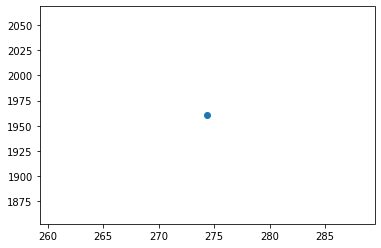

In [44]:
for x in front_IBEA:
    plt.scatter(x=x.objectives[0],y=x.objectives[1])
plt.show()

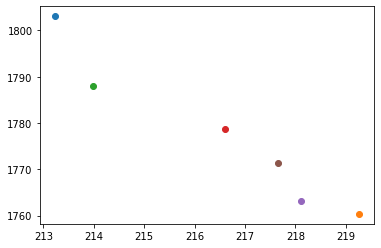

In [57]:
for x in front_NSGAII:
    plt.scatter(x=x.objectives[0],y=x.objectives[1])
plt.show()

In [42]:
%matplotlib inline
plt.ioff()
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plots=[]
prev = np.array([])
for index, y in enumerate(performance_observer_NSGAIII.front_history):
    #for x in y:
    fig,ax = plt.subplots(1,1,figsize =(10,10))#,subplot_kw={"projection": "3d"})
    #plt.xlim(0,1000)
    #plt.ylim(0,5000)
    objs = y#np.array([[o[0],o[1]] for o in y]) 
    #print(objs)
    if len(prev) != 0:
        ax.scatter(x = prev[:,0],y= prev[:,1],alpha=0.5,color="k")
    ax.scatter(x = objs[0],y= objs[1],label = "Evaluations: {}".format(index*10))
    if len(prev) == 0:
         prev = [np.array(objs)]
    prev = np.append(prev,[objs],axis=0)
    #print(prev)
    if type(prev)==list:
        prev=np.array(prev)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.xlabel("Fuel Consumption (L)",fontsize=24)
    plt.ylabel("Drive Time (Minutes)",fontsize=24)
    plt.legend(fontsize=24)
    plt.title("NSGA-III",fontsize=24)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plots.append(image)
    plt.close(fig)
    
    


In [39]:
%matplotlib inline
plt.ioff()
import matplotlib.pyplot as plt
plots=[]
prev = np.array([])
for y in fronts:
    #for x in y:
    fig,ax = plt.subplots(1,1,figsize =(10,10),subplot_kw={"projection": "3d"})
    #plt.xlim(0,1000)
    #plt.ylim(0,5000)
    objs = np.array([[o.objectives[0],o.objectives[1],abs(sum(o.constraints))] for o in y]) 
    #print(objs)
    if len(prev) != 0:
        ax.scatter(xs = prev[10:,0],ys= prev[10:,1],zs=prev[10:,2],alpha=0.5,color="k")
    ax.scatter(xs = objs[:,0],ys= objs[:,1],zs=objs[:,2])
    if len(prev) == 0:
         prev = np.array(objs)
    prev = np.append(prev,objs,axis=0)
    if type(prev)==list:
        prev=np.array(prev)
    ax.view_init(elev=25,azim=-50)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plots.append(image)
    plt.close(fig)
    
    


In [43]:

import imageio 
imageio.mimsave('./nsga3_50_halftime_cheapest_insertion.gif', plots, fps=30)


In [75]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime
from JMetalPy_modified import GeneticAlgorithmMultiObjective

parameter_list_GA = [{"mutation":0.5,"crossover":0.5}]#,{"mutation":0.5,"crossover":0.5}]
# for x in mutation_arange:
#     for y in crossover_arange:
#         parameter_list_GA.append({"mutation":np.round(x,2),"crossover":round(y,2)})
parameter_data_GA = []
computation_times_GA = []
results_GA = []
for index,param in enumerate(parameter_list_GA):
    plot_data_GA = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
    for x in range(20):
        problem_GA = VRP(data_model_input_single_objective)
        problem_GA.name = "GA"
        problem_GA.assignClosestEndPoint = True
        max_evaluations = 2000

        algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                        population_size=10,
                        offspring_population_size=10,
                        mutation=PermutationSwapMutation(param["mutation"]),
                        crossover=PMXCrossover(param["crossover"]),
                        selection=BestSolutionSelection(),
                        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                        ,population_evaluator=MultiprocessEvaluator()
                        )


        performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_GA)
        performance_observer_GA.maxEpochs= len(parameter_list_GA) * amount_of_runs
        performance_observer_GA.currentEpoch = (index*amount_of_runs) + x
        algorithm_GA.observable.register(observer=performance_observer_GA)
        start_time = datetime.now() 
        algorithm_GA.run()
        run_time = datetime.now() - start_time
        solutions_GA = algorithm_GA.get_result()
        print("Feasible solution found: {}".format(is_feasible(solutions_GA)))

        plot_data_GA['fitness'].append(performance_observer_GA.performances)
        plot_data_GA['fuel_consumption'].append(performance_observer_GA.total_consumptions)
        plot_data_GA['optimal_time'].append(performance_observer_GA.bestFitnessTime)
        plot_data_GA['maxDriveTimes'].append(performance_observer_GA.maxDriveTimes)
        plot_data_GA['violation'].append(performance_observer_GA.violations)
        plot_data_GA['IGD'].append(performance_observer_GA.IGD_values)
        plot_data_GA['paths'].append(solutions_GA.path)
        
    param["paramGroup"] = index
    param["algorithm"] = problem_GA.name
        
    parameter_data_GA.append({"parameters":param,"results":plot_data_GA})
    
    results_GA.append(get_results(solutions_GA.path,problem_GA.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_GA.append(performance_observer_GA.computing_time)
final_results_GA = generate_final_results(results_GA,computation_times_GA)   
final_results_GA

#saveParameterData(logPath,"GA_data_10_pop",parameter_data_GA)

Epoch:20 of 30
Evaluations: 2000/2000
Params: {'mutation': 0.5, 'crossover': 0.5}
IGD:1869.3137228758956
Best fitness: 2121.9136                          
Best total fuel consumption:272.58 
Best total drive time:1849.33                          
Computing time: 6.1s
Average computing speed: 327.76it/s                          
Current Route:[[15, 9, 43, 22, 42, 33, 23, 12, 20], [6, 47, 31, 8, 46, 27, 7, 44, 41, 45], [10, 11, 18, 39, 20], [35, 38, 19, 34, 29, 16, 13, 45], [0, 30, 36, 17, 25, 24, 50, 26, 37, 2], [21, 14, 48, 2], [40, 49, 3, 28, 20]]
Flags: []
Violation:0
Vehicle Amount:7
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),1712.357000,1712.357000,1712.357000,NaN
Total load (kg),17285,17285,17285.000000,NaN
Total Estimated Fuel Consumption (L) (Hao et al.),230.122415,230.122415,230.122415,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.337883,13.337883,13.337883,NaN
Total Estimated Fuel Consumption (L) (Wong et al.),190.797285,190.797285,190.797285,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),11.001909,11.001909,11.001909,NaN
Avg Speed (km/h),53.946901,53.946901,53.946901,NaN
Computaion Time,6.102105,6.102105,6.102105,NaN


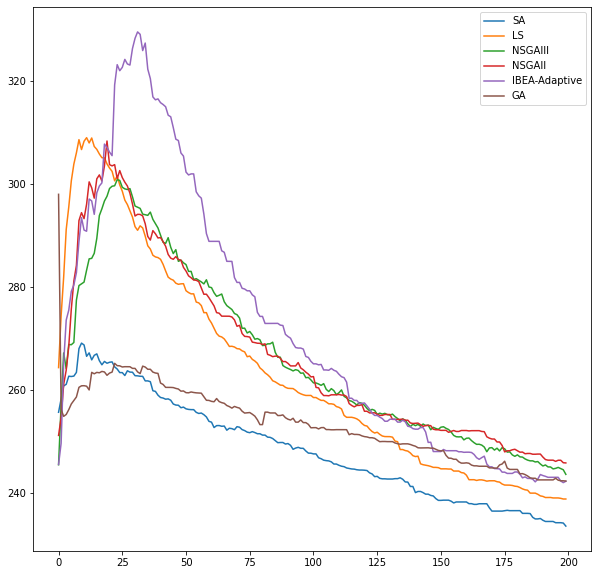

In [284]:
plt.figure(figsize=(10,10))

plt.plot(np.mean(plot_data_SA["fuel_consumption"],axis=0),label="SA")
plt.plot(np.mean(plot_data_LS["fuel_consumption"],axis=0),label="LS")
plt.plot(np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0),label="NSGAIII")
plt.plot(np.mean(plot_data_NSGAII["fuel_consumption"],axis=0),label="NSGAII")
plt.plot(np.mean(plot_data_IBEA["fuel_consumption"],axis=0),label="IBEA-Adaptive")
plt.plot(np.mean(plot_data_GA["fuel_consumption"],axis=0),label="GA")
plt.legend()

In [64]:
get_results(solutions_GA.path,problem_GA.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,283.177,2259,36.857210,13.015608,30.653023,10.824687,51.932613,19630,05:27:10.00
1,130.427,2067,16.852852,12.921291,14.979696,11.485119,63.813156,7358,02:02:38.00
2,363.913,3230,49.998472,13.739128,41.403618,11.377340,61.523753,21294,05:54:54.00
3,220.673,3608,29.824788,13.515377,23.443443,10.623612,40.240239,19742,05:29:02.00
4,114.895,759,14.597787,12.705328,12.036317,10.475927,43.027359,9613,02:40:13.00
5,128.904,1971,16.865045,13.083415,13.526980,10.493841,44.195657,10500,02:55:00.00
6,251.759,3391,34.191507,13.581047,27.866539,11.068736,55.362067,16371,04:32:51.00


In [41]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.selection import Selection
from jmetal.algorithm.multiobjective.hype import HYPE
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime

parameter_list_HYPE =[]#[{"mutation":0.4,"crossover":0.5}]#,{"mutation":0.5,"crossover":0.5}]
for x in mutation_arange:
    for y in crossover_arange:
        parameter_list_HYPE.append({"mutation":round(x,2),"crossover":round(y,2)})

computation_times_HYPE = []
results_HYPE = []
parameter_data_HYPE = []
for index,param in enumerate(parameter_list_HYPE):
    plot_data_HYPE = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}
    
    for x in range(amount_of_runs):

        problem_HYPE = VRP(data_model_input_multi_objective)
        problem_HYPE.name = "HYPE"
        problem_HYPE.assignClosestEndPoint = True
        max_evaluations = 2000
        reference_point = PermutationSolution(number_of_variables=problem_HYPE.number_of_variables,
                                              number_of_objectives=problem_HYPE.number_of_objectives,
                                              number_of_constraints=problem_HYPE.number_of_constraints)


        algorithm_HYPE = HYPE(
            problem=problem_HYPE,
            reference_point=reference_point,
            population_size=20,
            offspring_population_size=20,
            mutation=PermutationSwapMutation(param["mutation"]),
            crossover=PMXCrossover(param["crossover"]),
            termination_criterion=StoppingByEvaluations(max_evaluations),
            population_evaluator=MultiprocessEvaluator()
        )


        performance_observer_HYPE = PerformanceObserver(max_iter=max_evaluations,frequency=1)
        performance_observer_HYPE.maxEpochs= len(parameter_list_HYPE)
        performance_observer_HYPE.currentEpoch = (index*amount_of_runs) + x
        algorithm_HYPE.observable.register(observer=performance_observer_HYPE)

        algorithm_HYPE.run()

        solutions_HYPE = algorithm_HYPE.get_result()
        front_HYPE = get_non_dominated_solutions(solutions_HYPE)

        plot_data_HYPE['fitness'].append(performance_observer_HYPE.performances)
        plot_data_HYPE['fuel_consumption'].append(performance_observer_HYPE.total_consumptions)
        plot_data_HYPE['optimal_time'].append(performance_observer_HYPE.bestFitnessTime)
        plot_data_HYPE['maxDriveTimes'].append(performance_observer_HYPE.maxDriveTimes)
        plot_data_HYPE['violation'].append(performance_observer_HYPE.violations)
        plot_data_HYPE['IGD'].append(performance_observer_HYPE.IGD_values)
        plot_data_HYPE['paths'].append(front_HYPE[0].path)
        
    param["paramGroup"] = index
    param["algorithm"] = problem_HYPE.name
    parameter_data_HYPE.append({"parameters":param,"results":plot_data_HYPE})
    
    front_HYPE = get_non_dominated_solutions(solutions_HYPE)
    print("Feasible solution found: {}".format(is_feasible(solutions_HYPE[0])))
    results_HYPE.append(get_results(front_HYPE[0].path,problem_HYPE.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_HYPE.append(performance_observer_HYPE.computing_time)
final_results_HYPE = generate_final_results(results_HYPE,computation_times_HYPE)   
final_results_HYPE

saveParameterData(logPath,"HYPE_NO_RESET",parameter_data_HYPE)

Epoch:1350 of 45
Evaluations: 2000/2000 
IGD:1156.477364879147
Best fitness: 184.0785 --- 1141.7333                        
Best total fuel consumption:184.08 
Computing time: 3.99s                        
Average computing speed: 501.0it/s
Current Route:[[0, 14, 12, 19, 7, 13, 18, 20], [6, 1, 17, 9, 8, 4], [15, 11, 16, 3, 20]]
Flags: []                        
Violation:0
Vehicle amount:3
Feasible solution found: True


In [17]:
from IPython.display import display, HTML
from numpy import nan
from matplotlib.font_manager import FontProperties
def plotModelParameterComparison(parameterData, resultFieldsToPlot,plotTitles,yAxisLabels,amountToPlot=1):

    fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,15))
    #paramResults = parameterData[:amountToPlot]
    paramResults = pd.DataFrame(parameterData)
    for i,paramResult in paramResults.iterrows():#[:10]:
        for name, ax, title, ylabel in zip(resultFieldsToPlot,axs.flatten(),plotTitles,yAxisLabels):
            #print(paramResult['results'][name])
            ax.plot(eval(paramResult['results'])[name],label = paramResult['parameters'])
            ax.set_title(title,fontsize=16)
            ax.set_ylabel(ylabel,fontsize=16)
            ax.set_xlabel("Iterations",fontsize=16)
            ax.set_xticklabels(np.arange(0,5000,800))
            if paramResult['parameters']['algorithm'] in ["SA","GA"] and name == "fitness":
                ax.set_ylim(120,365)

    fontP = FontProperties()
    fontP.set_size('xx-small')
    plt.legend( title='Parameters', bbox_to_anchor=(1.05, 2.2), loc='upper left',fontsize=12)  

In [19]:
from numpy import nan
names = ["SA","LS"]#,"NSGAIII","NSGAII","GA","HYPE"]
dataPath = "../logs/2021-02-16/"

def read_parameter_data(path,names):
    
    data = []
    for name in names:
        inputData = pd.read_csv("{}{}.csv".format(path,name),dtype=object)
        inputData.infer_objects()#convert_dtypes(convert_string=False)
   
        data.append(inputData)
    return data
  
    
    
    
def make_best_plot(names,data,solutionAmount=1):
    returnData = []
    for name, algoData in zip(names,data):
        
        #algoData.results= literal_eval(algoData.results.app
        algoData.infer_objects()
        algoResults = []
        #algoResults
        for result in algoData.results:
            result = eval(result)
            fitness = np.array(result['fitness'])
            #print(fitness)
            algoResults.append(fitness[-1])
            #algoResults.append([x[-1] for x in fitness][0])
            
        argSortedResults = np.argsort(algoResults)
        
        
        tempDatas = algoData.iloc[argSortedResults[:solutionAmount]]
        #print(type(tempDatas.iloc[0]['results']))
        for index in range(len(tempDatas)):
            
            params = eval(tempDatas.iloc[index]["parameters"])
            dictValue = eval(tempDatas.iloc[index]['results'])
            #print(dictValue['fitness'])
            params["algorithm"]=name
            params["value"] = round(dictValue['fitness'][-1],2)
            tempDatas.iloc[index]["parameters"]=params
            returnData.append(tempDatas.iloc[index])
    
    return returnData



In [20]:
names = ["NSGAIII"]#,"NSGAII","GA","HYPE"]
dataPath = "../logs/2021-02-17/"
algorithm_data = make_best_plot(names,read_parameter_data(dataPath,names),2)
plotModelParameterComparison(algorithm_data,["fitness","fuel_consumption","maxDriveTimes","violation"],["Fitness","Fuel Consumption","Drive time","Violation"],["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"],2)


IndexError: positional indexers are out-of-bounds

<ipython-input-17-8f93f2855316>:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



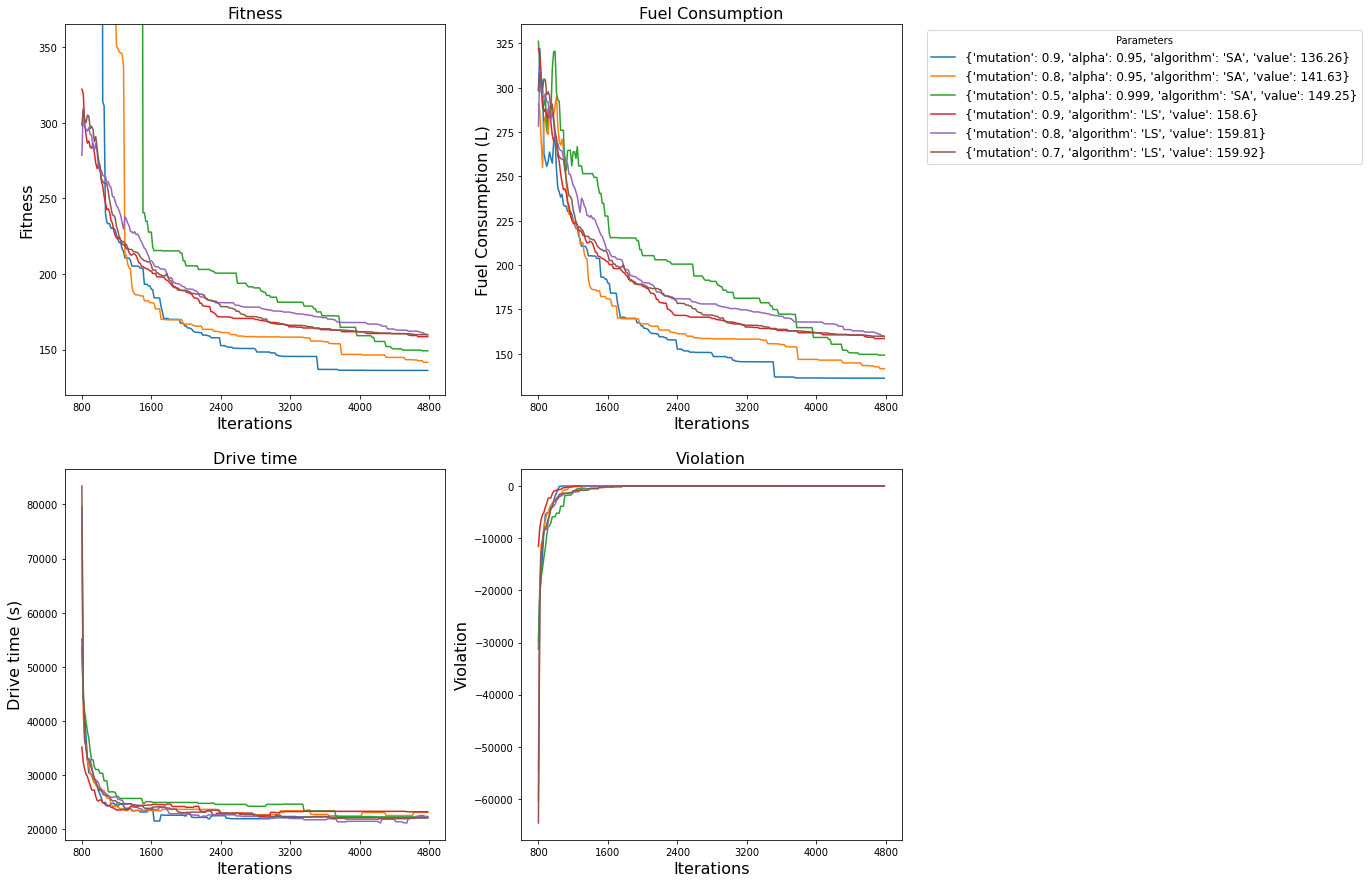

In [26]:
names = ["SA","LS"]
dataPath = "../logs/2021-02-16/"
algorithm_data = make_best_plot(names,read_parameter_data(dataPath,names),3)
plotModelParameterComparison(algorithm_data,["fitness","fuel_consumption","maxDriveTimes","violation"],["Fitness","Fuel Consumption","Drive time","Violation"],["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"],2)


(50.0, 53.0)

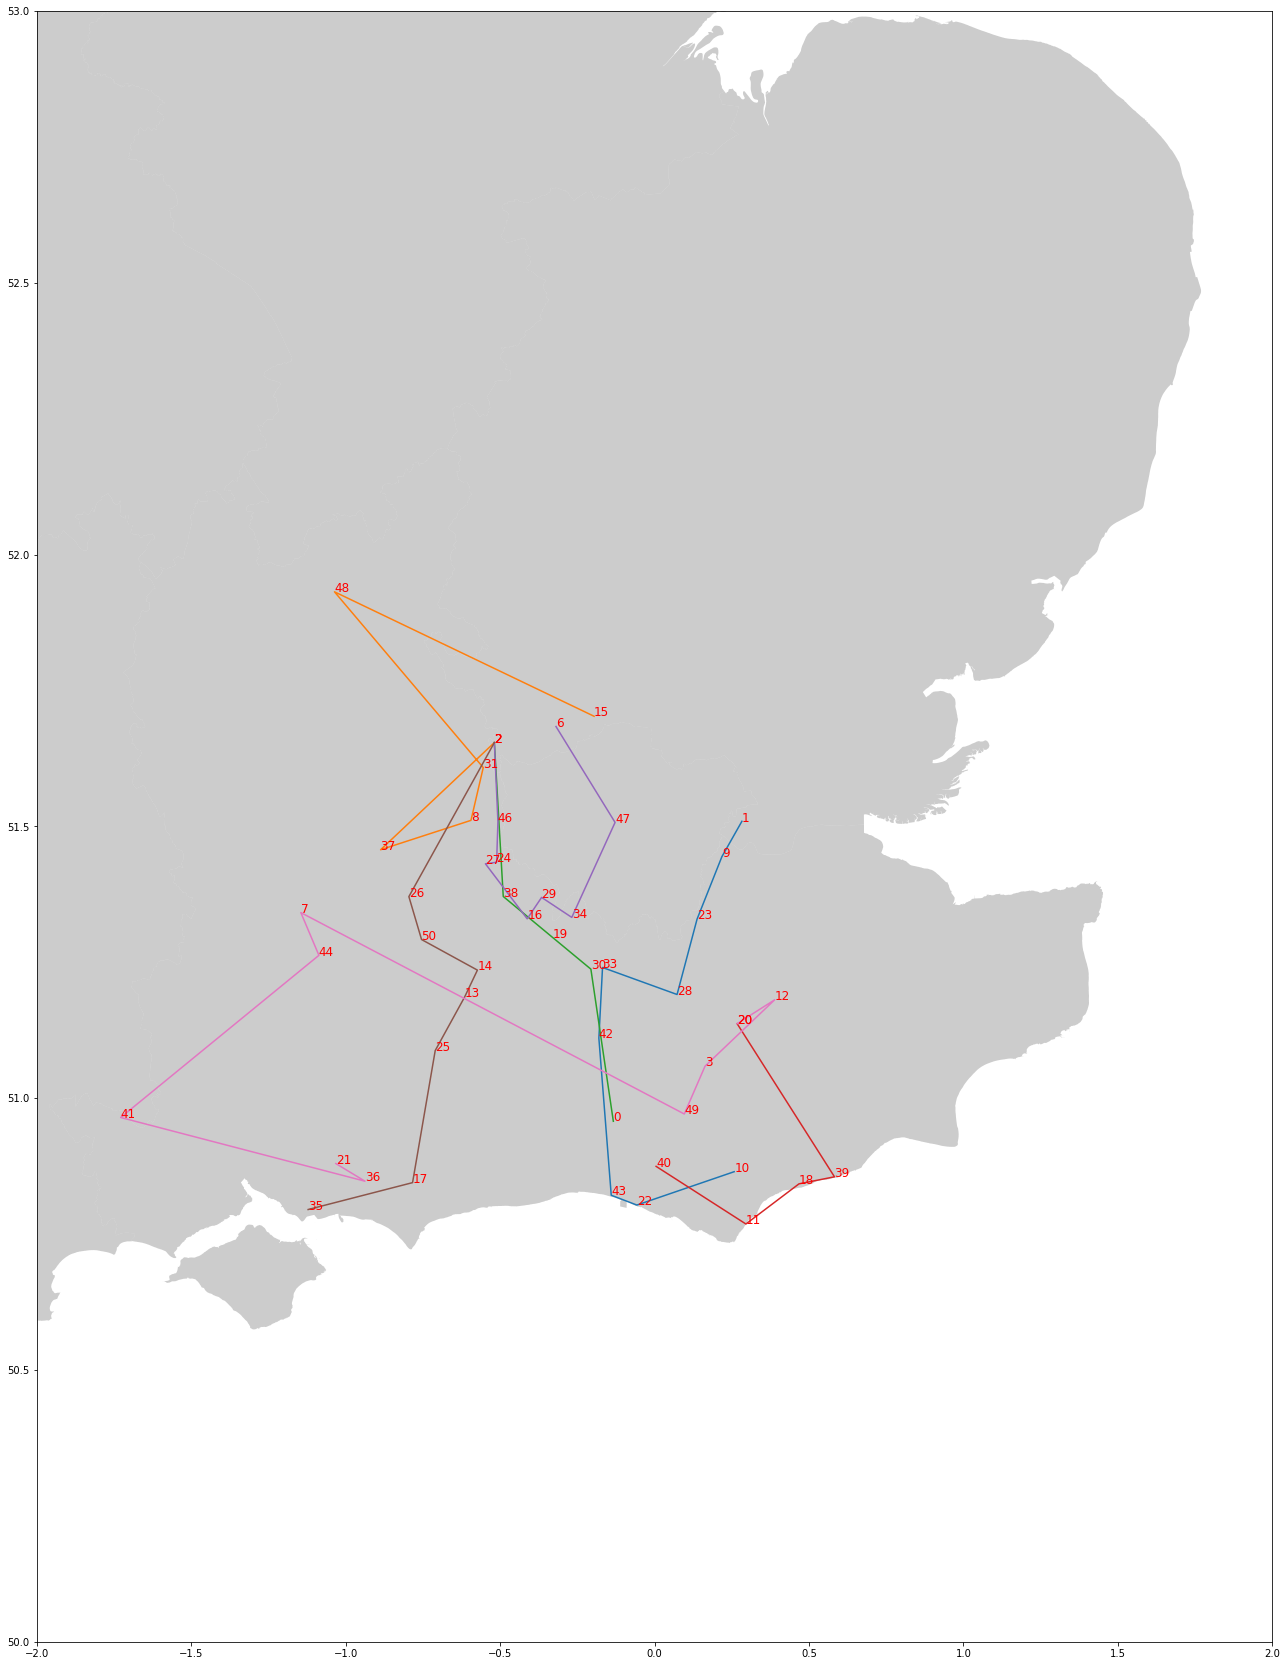

In [21]:
plot_routes(front_NSGAIII[0].path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
plt.xlim(-2,2)
plt.ylim(50,53)

In [22]:
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in front_NSGAIII[0].path:
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


In [23]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

In [28]:
import folium
from folium.plugins import PolyLineTextPath
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

centerpoint = [np.mean(points_coordinate[:,0]),np.mean(points_coordinate[:,1])]

folium_map = folium.Map(location=centerpoint, tiles='openstreetmap', zoom_start=8)

# Create popups for the pickup-points
position_popups = []
for solution_path,stop_demands in zip(solutions_NSGAIII[0].path,vehicle_stop_demands):
    position_popups.append(["Node: {}".format(node_id) for node_id in zip(solution_path[1:])])


markerCluster = MarkerCluster().add_to(folium_map)
# Add pickup-points and start positions to map
for startPos,stop_demands,stop_pos in zip(starts,position_popups,vehicle_stops):
    folium.Marker(location=list(points_coordinate[startPos]),popup="Startpos\nNode: {}".format(startPos),icon=folium.Icon(color='red', icon_color='white', icon='truck', angle=0, prefix='fa')).add_to(folium_map)
    if len(stop_pos)>1:

        MarkerCluster(stop_pos[:-1],popups=stop_demands[:-1]).add_to(folium_map)
        folium.Marker(location=list(stop_pos[-1]),popup="End\n{}".format(stop_demands[-1]),
                      icon=folium.Icon(color='green', icon_color='white', icon='flag-checkered', angle=0, prefix='fa')).add_to(markerCluster)
        
    else:
        folium.Marker(location=list(stop_pos[0]),popup="{}".format(stop_demands[0]),
                      icon=folium.Icon(color='red', icon_color='white', icon='exclamation-circle', angle=0, prefix='fa')).add_to(markerCluster)
        

colormap = folium.branca.colormap.LinearColormap(colors=['red','green', 'blue'],index=[0,int(len(vehicle_routes)/2),len(vehicle_routes)])
# Add routes to map with popups
for index,(route,route_load,route_fuel_consumption, route_distance) in enumerate(zip(vehicle_routes,solutions_NSGAIII[0].vehicle_loads,
                                                                                     solutions_NSGAIII[0].vehicle_fuel_consumptions,solutions_NSGAIII[0].vehicle_route_distances)):
    
    if(len(route) > 1):
        line = folium.PolyLine(route,color=colormap(index),
                               popup="Route Load: {}(kg)\nFuel consumption: {}(L)\nDistance: {}(km)".format(route_load,route_fuel_consumption,round(route_distance/1000,2))).add_to(folium_map)
        PolyLineTextPath(line, "\u27A4    ",repeat=True).add_to(folium_map)        

# Display the map
folium_map

In [17]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

centerpoint = [np.mean(points_coordinate[:,0]),np.mean(points_coordinate[:,1])]

folium_map = folium.Map(location=centerpoint, tiles='openstreetmap', zoom_start=8)
for index, coordinate in enumerate(points_coordinate):
    if index in starts:
        folium.Marker(location=[coordinate[0],coordinate[1]],icon=folium.Icon(color='red', icon_color='white', icon='truck', angle=0, prefix='fa')).add_to(folium_map)
    elif index in ends:
        folium.Marker(location=[coordinate[0],coordinate[1]],icon=folium.Icon(color='green', icon_color='white', angle=0, prefix='fa')).add_to(folium_map)
    else:
        
        folium.Marker(location=[coordinate[0],coordinate[1]]).add_to(folium_map)

folium_map
#folium.Marker()